In [7]:
import os
import gc
import math

# numpy
import numpy as np
import numpy.ma as ma

import jax
from jax import vmap, grad, jit, random
from jax.config import config
# from jax.experimental import optimizers
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

config.update("jax_enable_x64", True)

from skimage.restoration import estimate_sigma
from skimage.transform import resize

### CRPS
import properscoring as ps

### SSIM and PSNR
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# plotting
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')

# netCDF
import netCDF4 as nc

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import pickle

In [8]:
### model init

def nngp_params(key, depth = 1):

    subkeys = random.split(key, 3 + 2 * (depth - 1))

    base_layer = jnp.array([random.uniform(subkeys[0], minval = 0.75, maxval = 1.25), 
                            random.uniform(subkeys[1], minval = 0.1, maxval = 0.5),
                            random.uniform(subkeys[2], minval = 2, maxval = 3)])
    base_layer = [tuple(base_layer)]

    return base_layer
parallel_nngp_params = vmap(nngp_params, in_axes=(0, None))


def random_params(key, depth):
    nngp_par = nngp_params(key, depth)
    trend_par = trend_params(key)
    
    return [nngp_par, trend_par]
parallel_params = vmap(random_params, in_axes=(0, None))

@jit
def random_init(params):
    return opt_init(params)
parallel_init = vmap(random_init)

@jit
def param_abs(x):
    return jnp.abs(x)

@jit
def param_select(param_list, i):
    return tree_map(lambda x: x[i], param_list)

In [9]:
### model specification

depth = 10

## nngp functions
def nngp_kernel(params, x, y):
    x = jnp.array(x)
    y = jnp.array(y)
    
    kxx = params[0][1] + params[0][0] * (jnp.dot(x, x.T) / x.shape[0])
    kyy = params[0][1] + params[0][0] * (jnp.dot(y, y.T) / x.shape[0])
    kxy = params[0][1] + params[0][0] * (jnp.dot(x, y.T) / x.shape[0])
    
    for i in range(depth):
        
        ## kxy
        cor = jnp.clip(kxy / jnp.sqrt(kxx * kyy), -1.0 + 1e-16, 1.0 - 1e-16)
        theta = jnp.arccos(cor)
        trig = jnp.sin(theta) + (math.pi - theta) * jnp.cos(theta)
        kxy = params[0][1] + (params[0][0] / (2 * math.pi)) * jnp.sqrt(kxx * kyy) * trig
                
        ## kxx
        kxx = params[0][1] + (params[0][0] / 2) * kxx
    
        ## kyy
        kyy = params[0][1] + (params[0][0] / 2) * kyy
        
    return kxy

nngp_kernel = jit(nngp_kernel)
nngp_cov = jit(vmap(vmap(nngp_kernel, (None, None, 0)), (None, 0, None)))
nngp_var = jit(vmap(nngp_kernel, (None, 0, 0)))


def nngp_predict(params, xtest, xtrain, ytrain):
    n, p = ytrain.shape
        
    k_DD0 = nngp_cov(params, xtrain, xtrain)
    k_DD0 += jnp.diag(jnp.repeat(params[0][2], n))
    prec0 = jnp.linalg.inv(k_DD0)
    
    k_xD0 = nngp_cov(params, xtest, xtrain)
    
    proj0 = jnp.matmul(k_xD0, prec0)
    return jnp.matmul(proj0, ytrain)
nngp_predict = jit(nngp_predict)


def nngp_dist(params, xtest, xtrain, ytrain):
    n, p = ytrain.shape
        
    k_DD0 = nngp_cov(params, xtrain, xtrain)
    k_DD0 += jnp.diag(jnp.repeat(params[0][2], n))
    prec0 = jnp.linalg.inv(k_DD0)
    
    k_xD0 = nngp_cov(params, xtest, xtrain)
    proj0 = jnp.matmul(k_xD0, prec0)
    
    mu = jnp.matmul(proj0, ytrain)
    
    k_xx = nngp_var(params, xtest, xtest)
    sig = k_xx - jnp.sum(proj0 * k_xD0, axis = 1)
    
    return mu, sig
nngp_dist = jit(nngp_dist)

In [10]:
#### loss functions

def compute_lr(pgrad, scale = 2):
    leaves = jnp.array(tree_leaves(pgrad))
    lrs = 10**(-jnp.floor(jnp.log10(jnp.abs(leaves))) - scale)
    return lrs

def weighted_mse(k_inv, ytrain):
    return jnp.matmul(jnp.matmul(ytrain.T, k_inv), ytrain)
weighted_mse = jit(vmap(weighted_mse, (None, 1)))


def full_nll_loss(params, xtrain, ytrain):
    n, p = ytrain.shape

    k = nngp_cov(params, xtrain, xtrain)
    k += jnp.diag(jnp.repeat(params[0][2], n))
    k_inv = jnp.linalg.inv(k)
    
    mse = jnp.sum(weighted_mse(k_inv, ytrain))
    pen = p * jnp.linalg.slogdet(k)[1]
    nor = p/2 * jnp.log(2 * math.pi)
    return (0.5*mse + 0.5*pen + nor) / p
full_grad_loss = jit(grad(full_nll_loss))


def gradient_step(params, xtrain, ytrain):
        
    param, tdef = tree_flatten(params)
    pgrad = tree_flatten(full_grad_loss(params, xtrain, ytrain))[0]
    
    lrs = compute_lr(pgrad, 2)
    param = [a - lr * b for a, b, lr in zip(tree_leaves(param), pgrad, lrs)]
    
#     lr = 1e-3
#     param = [a - lr * b for a, b in zip(tree_leaves(param), pgrad)]
    params = tree_unflatten(tdef, param)
    params = tree_map(param_abs, params)
    return params
gradient_step = jit(gradient_step)
# parallel_gradient_step = vmap(gradient_step, in_axes = (0, None, None))

In [11]:
xhist = pickle.load(open('../data/saved/xhist_tas.pkl', 'rb'))
xrcp = pickle.load(open('../data/saved/xrcp_tas.pkl', 'rb'))

In [12]:
nval = 72
ntest = len(xrcp[0])
ntest = 72 + 336
nmod = len(xhist)

In [13]:
### 1 backwards lag

nmod = len(xhist)
ntrain = xhist[0].shape[0]
ntest = xrcp[0].shape[0]

mse_nolag_list = []
for m1 in trange(nmod):
    _, nlat, nlon = xhist[m1].shape

    #### construct training set
    xtrain = []
    for m2 in range(nmod):
        if m1 != m2:
            x1 = xhist[m2].reshape(ntrain, -1)
            x2 = xrcp[m2][0:nval].reshape(nval, -1)

            xtrain.append(np.vstack([x1, x2]))

    xmean = np.array([np.mean(f, axis = 1) for f in xtrain])
    xtrain = jnp.hstack(xtrain)
    nobs = xtrain.shape[0]

    xtrain = jnp.stack([xtrain[1:], xtrain[:-1]], axis = 2)
    xtrain = xtrain.reshape(nobs-1, -1)

    y1 = xhist[m1].reshape(ntrain, -1)
    y2 = xrcp[m1][0:nval].reshape(nval, -1)

    ytrain = jnp.array(np.vstack([y1, y2]))
    ymean = jnp.mean(ytrain, axis = 1)

    x = jnp.vstack([xmean]).T
    beta = jnp.linalg.inv(x.T @ x) @ x.T @ ymean
    ytrain = ytrain - (x @ beta)[:,None]
    ytrain = ytrain[1:]

    #### test
    xtest = []
    for m2 in range(nmod):
        if m1 != m2:
            xtest.append(xrcp[m2][nval:ntest].reshape(ntest-nval, -1))

     ## center and join data
    xmean = np.array([np.mean(f, axis = 1) for f in xtest])
    xtest = jnp.hstack(xtest)
    nobs = xtest.shape[0]

    xtest = jnp.stack([xtest[1:], xtest[:-1]], axis = 2)
    xtest = xtest.reshape(nobs-1, -1)

    ytest = np.array(xrcp[m1][nval:ntest]).reshape(ntest-nval, -1)
    ytest = ytest[1:]
    x = jnp.vstack([xmean]).T[1:]

    ## randomize ensemble init
    key = random.PRNGKey(1023)
    params_nolag = nngp_params(key, depth)

    ## fit ensemble
    for _ in trange(300, leave = False):
        params_nolag = gradient_step(params_nolag, xtrain, ytrain)

    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))

    sgpr_lag1 = nngp_predict(params_nolag, xtest, xtrain, ytrain)
    sgpr_lag1 += (x @ beta)[:,None]
    sgpr_lag1 = sgpr_lag1.reshape((-1, nlat, nlon))

    np.save(f'lag_predictions/tas_lag1_{m1}.npz', sgpr_lag1)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [14]:
### 1 backwards lag and 1 forwards lag

nmod = len(xhist)
ntrain = xhist[0].shape[0]
ntest = xrcp[0].shape[0]

mse_nolag_list = []
for m1 in trange(nmod):
    _, nlat, nlon = xhist[m1].shape

    #### construct training set
    xtrain = []
    for m2 in range(nmod):
        if m1 != m2:
            x1 = xhist[m2].reshape(ntrain, -1)
            x2 = xrcp[m2][0:nval].reshape(nval, -1)

            xtrain.append(np.vstack([x1, x2]))

    xmean = np.array([np.mean(f, axis = 1) for f in xtrain])
    xtrain = jnp.hstack(xtrain)
    nobs = xtrain.shape[0]

    xtrain = jnp.stack([xtrain[2:], xtrain[1:-1], xtrain[:-2]], axis = 2)
    xtrain = xtrain.reshape(nobs-2, -1)


    y1 = xhist[m1].reshape(ntrain, -1)
    y2 = xrcp[m1][0:nval].reshape(nval, -1)

    ytrain = jnp.array(np.vstack([y1, y2]))
    ymean = jnp.mean(ytrain, axis = 1)

    x = jnp.vstack([xmean]).T
    beta = jnp.linalg.inv(x.T @ x) @ x.T @ ymean
    ytrain = ytrain - (x @ beta)[:,None]
    ytrain = ytrain[1:-1]

    #### test
    xtest = []
    for m2 in range(nmod):
        if m1 != m2:
            xtest.append(xrcp[m2][nval:ntest].reshape(ntest-nval, -1))

    ## center and join data
    xmean = np.array([np.mean(f, axis = 1) for f in xtest])
    xtest = jnp.hstack(xtest)
    nobs = xtest.shape[0]

    xtest = jnp.stack([xtest[2:], xtest[1:-1], xtest[:-2]], axis = 2)
    xtest = xtest.reshape(nobs-2, -1)

    ytest = np.array(xrcp[m1][nval:ntest]).reshape(ntest-nval, -1)
    ytest = ytest[1:-1]
    x = jnp.vstack([xmean]).T[1:-1]

    ## randomize ensemble init
    key = random.PRNGKey(1023)
    params_nolag = nngp_params(key, depth)

    ## fit ensemble
    for _ in trange(300, leave = False):
        params_nolag = gradient_step(params_nolag, xtrain, ytrain)

    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))

    sgpr_lag1 = nngp_predict(params_nolag, xtest, xtrain, ytrain)
    sgpr_lag1 += (x @ beta)[:,None]
    sgpr_lag1 = sgpr_lag1.reshape((-1, nlat, nlon))

    np.save(f'lag_predictions/tas_lag2_{m1}.npz', sgpr_lag1)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [37]:
months = 12 * 10
decades = int((ntest-nval)/(months))

In [65]:
# mse_lag1_time = []
# mse_lag2_time = []
# mse_lag1_model = []
# mse_lag2_model = []

months = 12 * 10
decades = 8

lag0_mse = np.zeros([decades, nmod])
lag1_mse = np.zeros([decades, nmod])
lag2_mse = np.zeros([decades, nmod])

for m1 in trange(nmod):
    
    ytest = np.array(xrcp[m1][nval:ntest])
    nlat = ytest.shape[1]
    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))
    
    # lag 0
    ytest_lag0 = ytest
    nngpr_lag0 = np.load(f'tas_predictions/sgpr_tas_{m1}.npz.npy')
    
    # lag 1
    ytest_lag1 = ytest[1:]
    nngpr_lag1 = np.load(f'lag_predictions/tas_lag1_{m1}.npz.npy')
    
    # lag 2
    ytest_lag2 = ytest[1:-1]
    nngpr_lag2 = np.load(f'lag_predictions/tas_lag2_{m1}.npz.npy')
    
    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))
    scale /= np.mean(scale)
    
    for d in range(decades):
        
        ytest_lag0_dec = ytest_lag0[(months*d):(months*(d+1))].astype('float32')
        ytest_lag1_dec = ytest_lag1[(months*d):(months*(d+1))].astype('float32')
        ytest_lag2_dec = ytest_lag2[(months*d):(months*(d+1))].astype('float32')
        
        nngpr_lag0_dec = nngpr_lag0[(months*d):(months*(d+1))].astype('float32')
        nngpr_lag1_dec = nngpr_lag1[(months*d):(months*(d+1))].astype('float32')
        nngpr_lag2_dec = nngpr_lag2[(months*d):(months*(d+1))].astype('float32')
        
        lag0_mse[d, m1] = np.mean((nngpr_lag0_dec - ytest_lag0_dec)**2 * scale[None,:,None])
        lag1_mse[d, m1] = np.mean((nngpr_lag1_dec - ytest_lag1_dec)**2 * scale[None,:,None])
        lag2_mse[d, m1] = np.mean((nngpr_lag2_dec - ytest_lag2_dec)**2 * scale[None,:,None])

  0%|          | 0/16 [00:00<?, ?it/s]

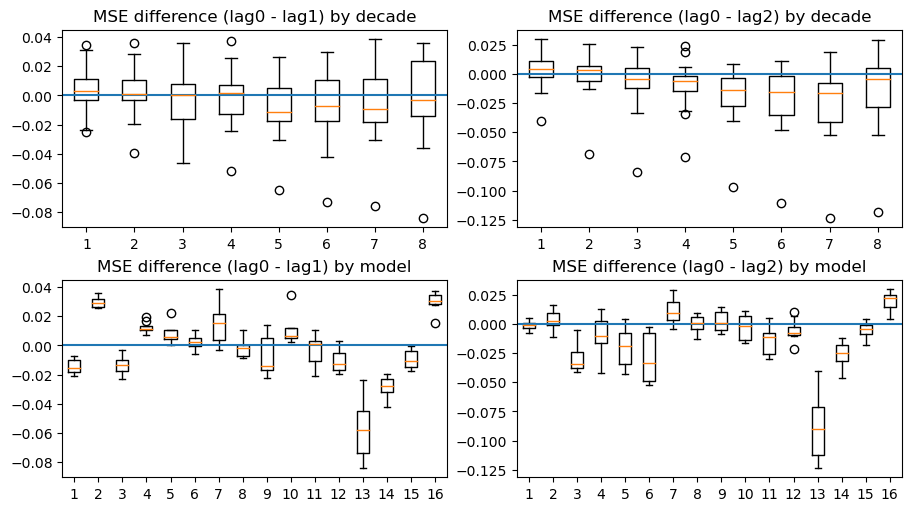

In [72]:
fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize = (9, 5))

ax[0,0].boxplot(lag0_mse.T - lag1_mse.T)
ax[0,0].axhline(0)
ax[0,0].set_title('MSE difference (lag0 - lag1) by decade')

ax[0,1].boxplot(lag0_mse.T - lag2_mse.T)
ax[0,1].axhline(0)
ax[0,1].set_title('MSE difference (lag0 - lag2) by decade')

ax[1,0].boxplot(lag0_mse - lag1_mse)
ax[1,0].axhline(0)
ax[1,0].set_title('MSE difference (lag0 - lag1) by model')

ax[1,1].boxplot(lag0_mse - lag2_mse)
ax[1,1].axhline(0)
ax[1,1].set_title('MSE difference (lag0 - lag2) by model')
plt.show()